<a href="https://colab.research.google.com/github/jude1997felix/fastText/blob/main/fastText_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing FastText Library

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make

--2020-10-26 16:57:23--  https://github.com/facebookresearch/fastText/archive/0.2.0.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/0.2.0 [following]
--2020-10-26 16:57:23--  https://codeload.github.com/facebookresearch/fastText/zip/0.2.0
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip’

0.2.0.zip               [  <=>               ]   4.10M  16.1MB/s    in 0.3s    

2020-10-26 16:57:24 (16.1 MB/s) - ‘0.2.0.zip’ saved [4304799]

Archive:  0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  inflating: fastText

In [ ]:
! pip install fasttext

     |████████████████████████████████| 71kB 2.8MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3023432 sha256=07935604a7e4e27884a5c6054f5681fd346a00fac61d58b57d7c138b2940dca1
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


## TSNE functions


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
def tsne_plot(ittr,neighours,perp):
  labels = []
  tokens = []
  model = fasttext.train_supervised(input="/content/mails_train.txt", lr=0.75, epoch=50, wordNgrams=neighours )
  for word in model.words:
    tokens.append(model[word])
    labels.append(word)
      
  tsne_model = TSNE(perplexity=perp, n_components=2, init='pca', n_iter=ittr, random_state=23)
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])
          
  plt.figure(figsize=(20, 20)) 
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i], xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right', va='bottom')
  plt.savefig('/content/tsne_plot.png')
  plt.show()

## Fasttext supervised classifier

In [ ]:
import pandas as pd
import csv
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, StratifiedShuffleSplit
import fasttext
from io import StringIO
import re

In [ ]:
cols = ['labels','text']
mails = pd.read_csv('/content/mail_dataset.csv',names=cols)

# preparing the dataset to the format required for fasttext classifier.
# For __label__<X> __label__<Y> ... <Text>
mails = mails[cols]
mails = mails[pd.notnull(mails['text'])]
mails.columns = ['label', 'text']
mails['label']=['__label__'+s.replace(' or ', '$').replace(', or ','$').replace(',','$').replace(' ','_').replace(',','__label__').replace('$$','$').replace('$',' __label__').replace('___','__') for s in mails['label']]
mails['label']
mails['text']= mails['text'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)

# Converting all the letters to lower case
for col in mails.columns:
  for i in range(len(mails)):
    mails[col][i] = mails[col][i].lower()

mails.head()

,label,text
0,__label__`a`,` i need a status update by monday or produc...
1,__label__`re`,` our recommendation is that we stay with do...
2,__label__`pr`,` shane and i will discuss and reply to you`
3,__label__`ing`,` thank you for the opportunity to bid on th...
4,__label__`re`,` you can probably safely shave ~ 10 â€“ 15...


In [ ]:
X = mails['text']
y = mails['label']

train_data = r'/content/mails_train.txt'
test_data = r'/content/mails_test.txt'
# Removing unwanted characters from the dataset
for i in range(len(X)):
  test = [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in X[i].split("\n")]
  X[i] = test[0]
i=0
splits = 5
sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X,y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  train = y_train + X_train
  test = y_test + X_test
  # Writing the train data as a text file
  train.to_csv(train_data, index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

   # Writing the test data as a text file 
  test.to_csv(test_data, index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

  # Training model using Fasttext 
  model = fasttext.train_supervised(input="/content/mails_train.txt", lr=0.75, epoch=50, wordNgrams=4 )
  _,prec,recall = model.test("/content/mails_test.txt")
  i=i+1
  print("Split-{}".format(i))
  print("Precision = {} Recall = {}".format(prec,recall)) 
  print('----------------------------------------------')

# Functions
# printstatments
# variable names
# readme
# filenames

Split-1
Precision = 0.573170731707317 Recall = 0.573170731707317
----------------------------------------------
Split-2
Precision = 0.6707317073170732 Recall = 0.6707317073170732
----------------------------------------------
Split-3
Precision = 0.6951219512195121 Recall = 0.6951219512195121
----------------------------------------------
Split-4
Precision = 0.6585365853658537 Recall = 0.6585365853658537
----------------------------------------------
Split-5
Precision = 0.6341463414634146 Recall = 0.6341463414634146
----------------------------------------------


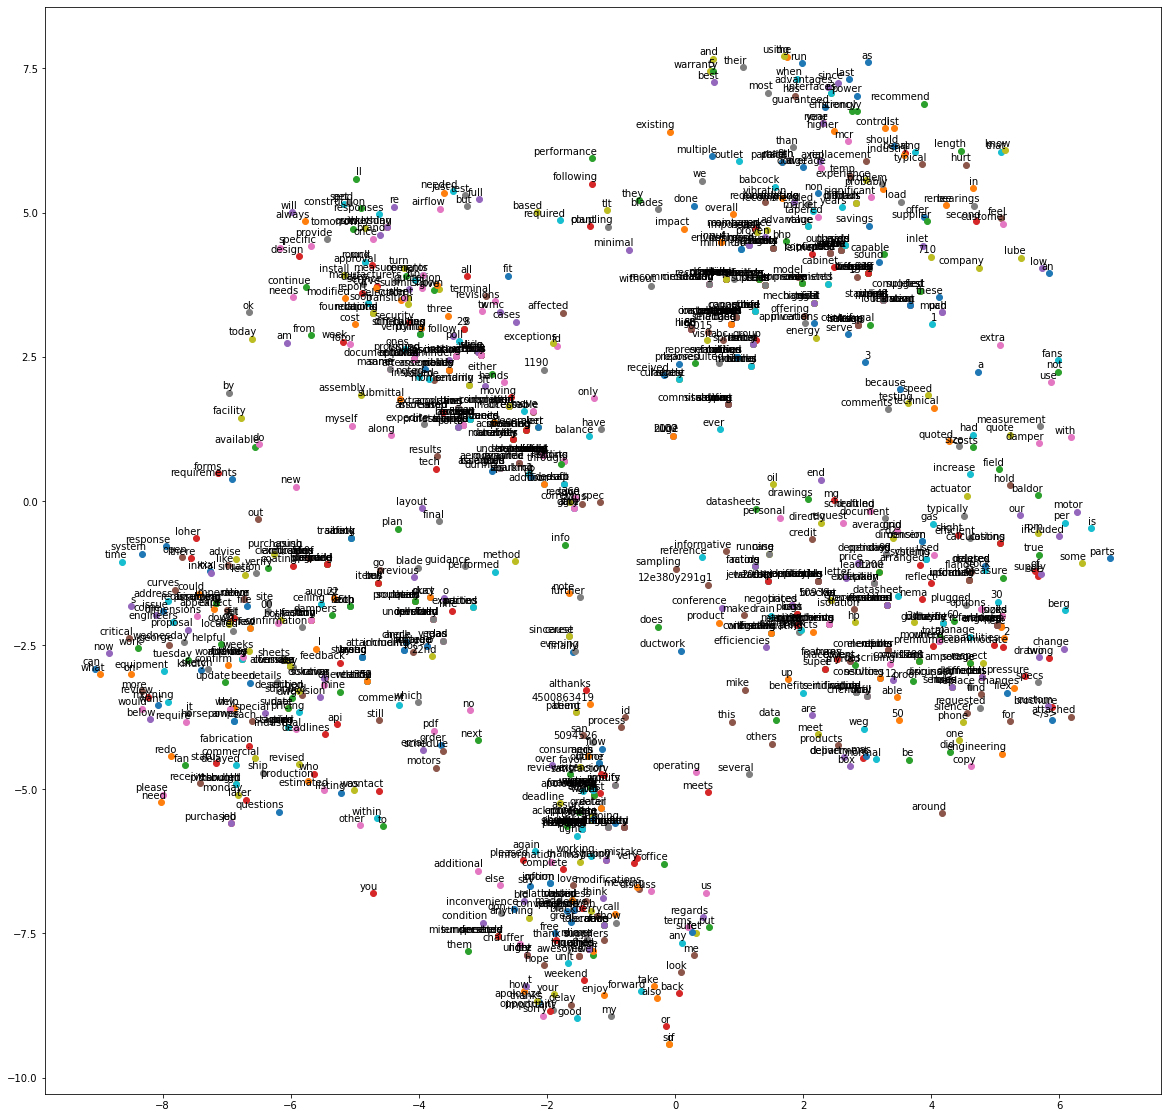

In [ ]:
tsne_plot(3000,1,250)

In [ ]:
! fast

/bin/bash: fast: command not found


## Auto fine tuning 



In [ ]:
# Hyper parameters are auto fine tuned
model1 = fasttext.train_supervised(input="/content/mails_train.txt", autotuneValidationFile='/content/mails_test.txt') 
model1.test('/content/mails_test.txt')

(82, 0.7317073170731707, 0.7317073170731707)

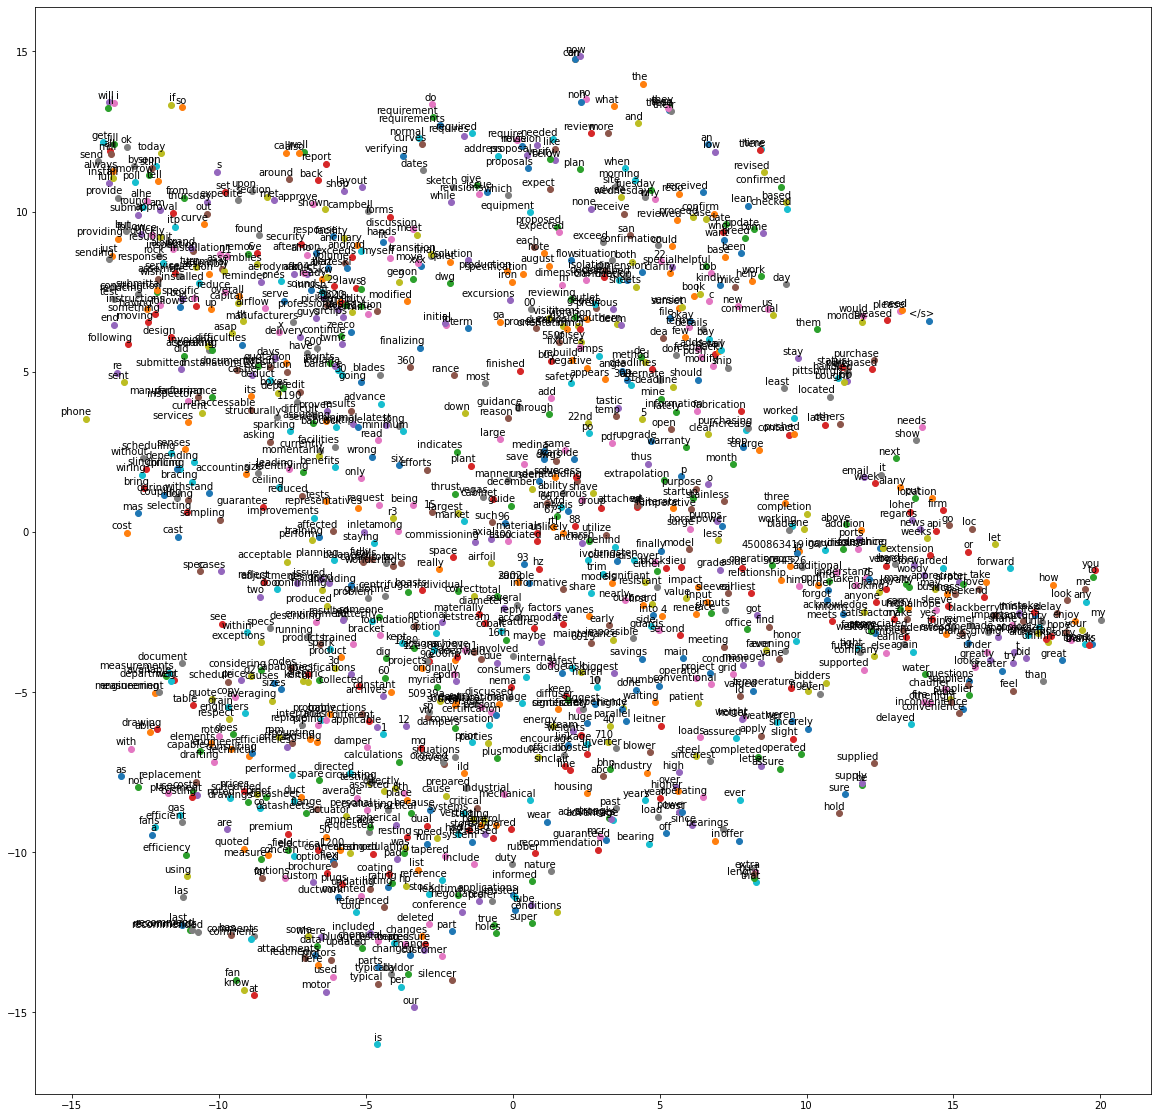

In [ ]:
tsne_plot(model1)

In [ ]:
a = input()
print(a)

100
100
